# Try this exercise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

Ok, so why did we change kernels in the last example?  Inquiring minds want to know.

## Part 1

Re-run gaussian process analysis for the last example using the `RBF` kernel.  Try with and without the `WhiteKernel`.  Comment on your results.

### Answer:

Here I've made two GPRs using an RBF kernel on the same data as before - one with `WhiteKernel` and one without. We see that in using this non-periodic kernel, specifically one with only a single parameter, it seems to be overfitting using an extreme lengthscale without `WhiteKernel`. This is because the only hyperparameter available to fit the data is the lengthscale, so optimizing makes the lengthscale so small that it reaches all the points. On the other hand, introducing a (constant) noise parameter through another kernel allows the lengthscale to be much longer while maximizing the log-likelihood of the model fitting the data.

If we had used the periodic kernel from before (or one with more/different parameters), we may have been able to fit the data better without ovrefitting. However, the nature of the data makes a single RBF kernel untrustworthy.

In [2]:
rng = np.random.RandomState(0)

# Generate the same sample data
X = 15 * rng.rand(100)
y = np.sin(X) + 3 * (0.5 - rng.rand(X.shape[0]))

In [3]:
def get_gpr(X, y, kernel, wk=True, noise_level=1e-10, *args, **kwargs):
    if wk:
        kern = kernel + WhiteKernel(noise_level)
    else:
        kern = kernel

    gpr = GaussianProcessRegressor(kernel=kern, *args, **kwargs)
    gpr.fit(X[:, np.newaxis], y)
    
    return gpr

kernel = RBF(1., length_scale_bounds=(1e-2, 1e2))
noise_level = 1e-10

gp_nonoise = get_gpr(X, y, kernel, wk=False)
gp_noise = get_gpr(X, y, kernel, noise_level=noise_level)

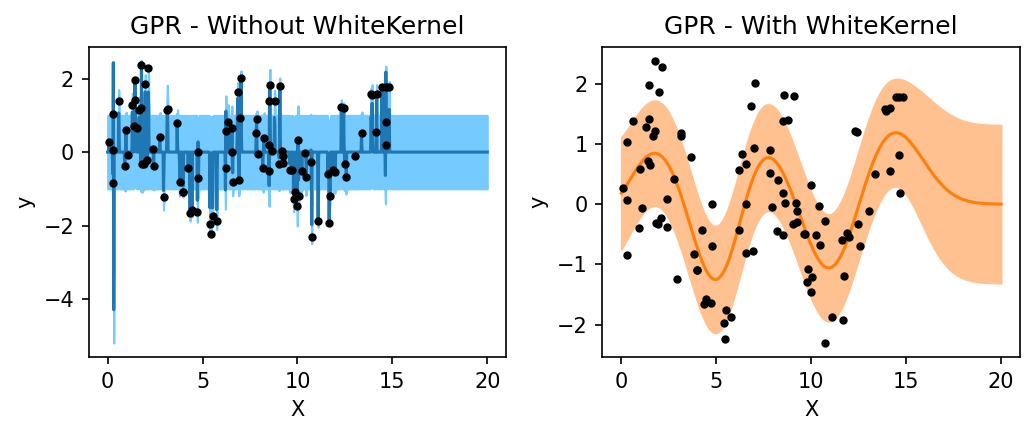

In [4]:
X_plot = np.linspace(0, 20, 1000)

mean_nonoise, std_nonoise = gp_nonoise.predict(X_plot[:, np.newaxis], return_std=True)
mean_noise, std_noise = gp_noise.predict(X_plot[:, np.newaxis], return_std=True)

fig, ax = plt.subplots(1, 2, dpi=150, figsize=(7, 3))

[_ax.plot(X, y, 'ko', ms=3) for _ax in ax]

ax[0].plot(X_plot, mean_nonoise, '-', c='tab:blue', label='No noise', zorder=-1)
ax[0].fill_between(X_plot, mean_nonoise - std_nonoise, mean_nonoise + std_nonoise,
                   color='#75caff', zorder=-2)
ax[0].set_title('GPR - Without WhiteKernel')

ax[1].plot(X_plot, mean_noise, '-', c='tab:orange', label='With noise', zorder=-1)
ax[1].fill_between(X_plot, mean_noise - std_noise, mean_noise + std_noise,
                   color='#ffc18f', zorder=-3)
ax[1].set_title('GPR - With WhiteKernel')

[_ax.set_xlabel('X') for _ax in ax]
[_ax.set_ylabel('y') for _ax in ax]


plt.tight_layout()
plt.show()

## Part 2

Re-run the kernel ridge analysis using the `RBF` kernel.  Comment on your results.

### Answer:

Below I did a kernel ridge regression on the same data, this time using the RBF kernel. We find that the result looks like a decent fit (not overfitted) using just the single lengthscale parameter.

In [5]:
param_grid = {"alpha": np.logspace(0, -3, 4),
              "kernel": [RBF(l) for l in np.logspace(-2, 2, 10)]}

kr = GridSearchCV(KernelRidge(), param_grid=param_grid, verbose=0)
kr.fit(X[:, np.newaxis], y)

GridSearchCV(estimator=KernelRidge(),
             param_grid={'alpha': array([1.   , 0.1  , 0.01 , 0.001]),
                         'kernel': [RBF(length_scale=0.01),
                                    RBF(length_scale=0.0278),
                                    RBF(length_scale=0.0774),
                                    RBF(length_scale=0.215),
                                    RBF(length_scale=0.599),
                                    RBF(length_scale=1.67),
                                    RBF(length_scale=4.64),
                                    RBF(length_scale=12.9),
                                    RBF(length_scale=35.9),
                                    RBF(length_scale=100)]})

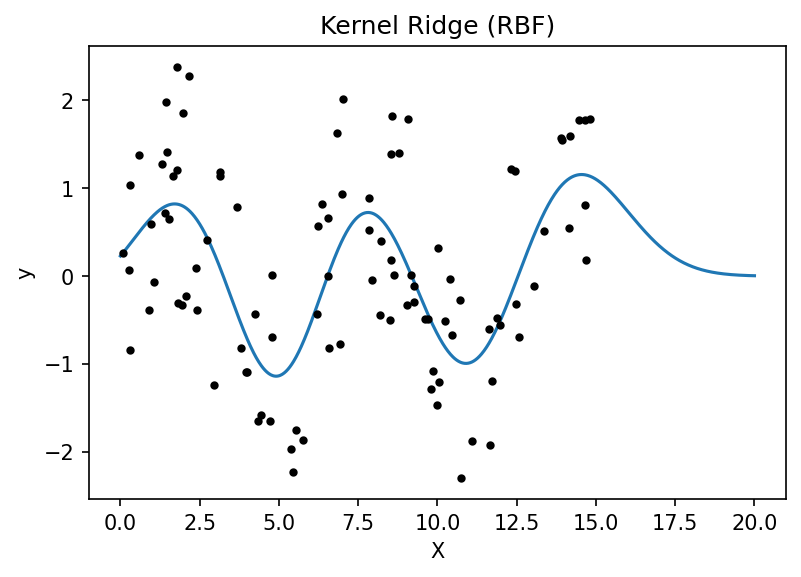

In [6]:
kr_model = kr.predict(X_plot[:, np.newaxis])

fig, ax = plt.subplots(dpi=150)

ax.plot(X, y, 'ko', ms=3)
ax.plot(X_plot, kr_model, '-', c='tab:blue', zorder=-1)

ax.set_xlabel('X')
ax.set_ylabel('y')
ax.set_title('Kernel Ridge (RBF)')

plt.show()